In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
pd.set_option('display.max_columns',None)

from sklearn.model_selection import train_test_split,cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as r
from scipy import stats


In [2]:
#loading the data set 
df=pd.read_csv('C:\\Users\\admin\\Desktop\\Projects\\Car Price\\CarPrice_Assignment.csv')
df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


# Initial Intuition on features

Symboling:
    As symboling is the process which is assosciated with the price(which mean symboling will be done once the Price is fixed).
    In any model building, it is not a good practice to include the features which are derived after the predicted 
    feature(which here is price). 
        So we can directly drop this feature.

CarName:Car price mostly depends on the brand of the car. We ca extract the maker of the car and divide it into low,medium
and high bidget cars .

Car_length: In US the width of the car plays an imp role as regulations are set by Govt on it. Where as in India its on car length.

WheelBase : Wheelbase depends on car length . Price of the car will be decided based on car length(considering wheel base vs length)
            So, we can drop this feature.
             
Engine size(Engine capacity): Its the feature which is calculated from bore , stroke, number of cylinders. So, we can drop 
    those three features.
                
                Engine size= (3.1416*bore^2*stroke*no. of cylinders)/4  cubic inches

In [3]:
#before exploring the further, lets check if there are any null values in the data.

df.isnull().sum()[df.columns[df.isnull().sum()>0]]

Series([], dtype: int64)

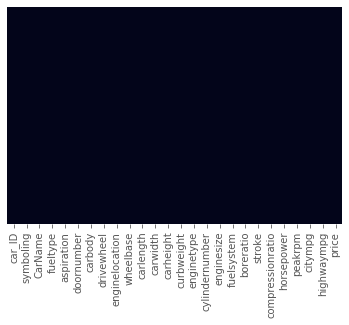

In [4]:
#visualizing nulls
sns.heatmap(df.isnull(),cbar=False,yticklabels=False)
plt.show()
#no nulls in the dataset

In [5]:
#removing car id and symboling, Car name
df.drop(['car_ID','symboling'],1,inplace=True)

In [6]:
#We will proceed with analysing numerical and categorical columns saperately

df_numeric=df.select_dtypes(include=['int64','float64'])
df_catg=df.select_dtypes(include=object)

# Exploratory Data Analysis and Feature Engineering

# Numerical Featurs Analysis

In [7]:
df_numeric.head()

,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495.0
1,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500.0
2,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,16500.0
3,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,24,30,13950.0
4,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,18,22,17450.0


In [8]:
#1:Deriving Avg mpg based on city and highway mpg 
def Avg_mpg(x):
    city=x[0]
    highway=x[1]
    return ( (city+highway)/2)

In [9]:
Avgmpg=df_numeric[['citympg','highwaympg']].apply(Avg_mpg,axis=1)
df_numeric.insert(len(df_numeric.columns)-1,'Avgmpg',Avgmpg)

In [10]:
#dropping the features
df_numeric.drop(['citympg','highwaympg'],1,inplace=True)

In [11]:
df_numeric.describe().T

,count,mean,std,min,25%,50%,75%,max
wheelbase,205.0,98.756585,6.021776,86.60,94.50,97.00,102.40,120.90
carlength,205.0,174.049268,12.337289,141.10,166.30,173.20,183.10,208.10
carwidth,205.0,65.907805,2.145204,60.30,64.10,65.50,66.90,72.30
carheight,205.0,53.724878,2.443522,47.80,52.00,54.10,55.50,59.80
curbweight,205.0,2555.565854,520.680204,1488.00,2145.00,2414.00,2935.00,4066.00
enginesize,205.0,126.907317,41.642693,61.00,97.00,120.00,141.00,326.00
boreratio,205.0,3.329756,0.270844,2.54,3.15,3.31,3.58,3.94
stroke,205.0,3.255415,0.313597,2.07,3.11,3.29,3.41,4.17
compressionratio,205.0,10.142537,3.972040,7.00,8.60,9.00,9.40,23.00
horsepower,205.0,104.117073,39.544167,48.00,70.00,95.00,116.00,288.00


# Observations:
-> We can see that horse power, curb weight,price,engne size are the features which are not normally distributed indicating that these have outliers.

->All the features are in different units.Have to perform scaling


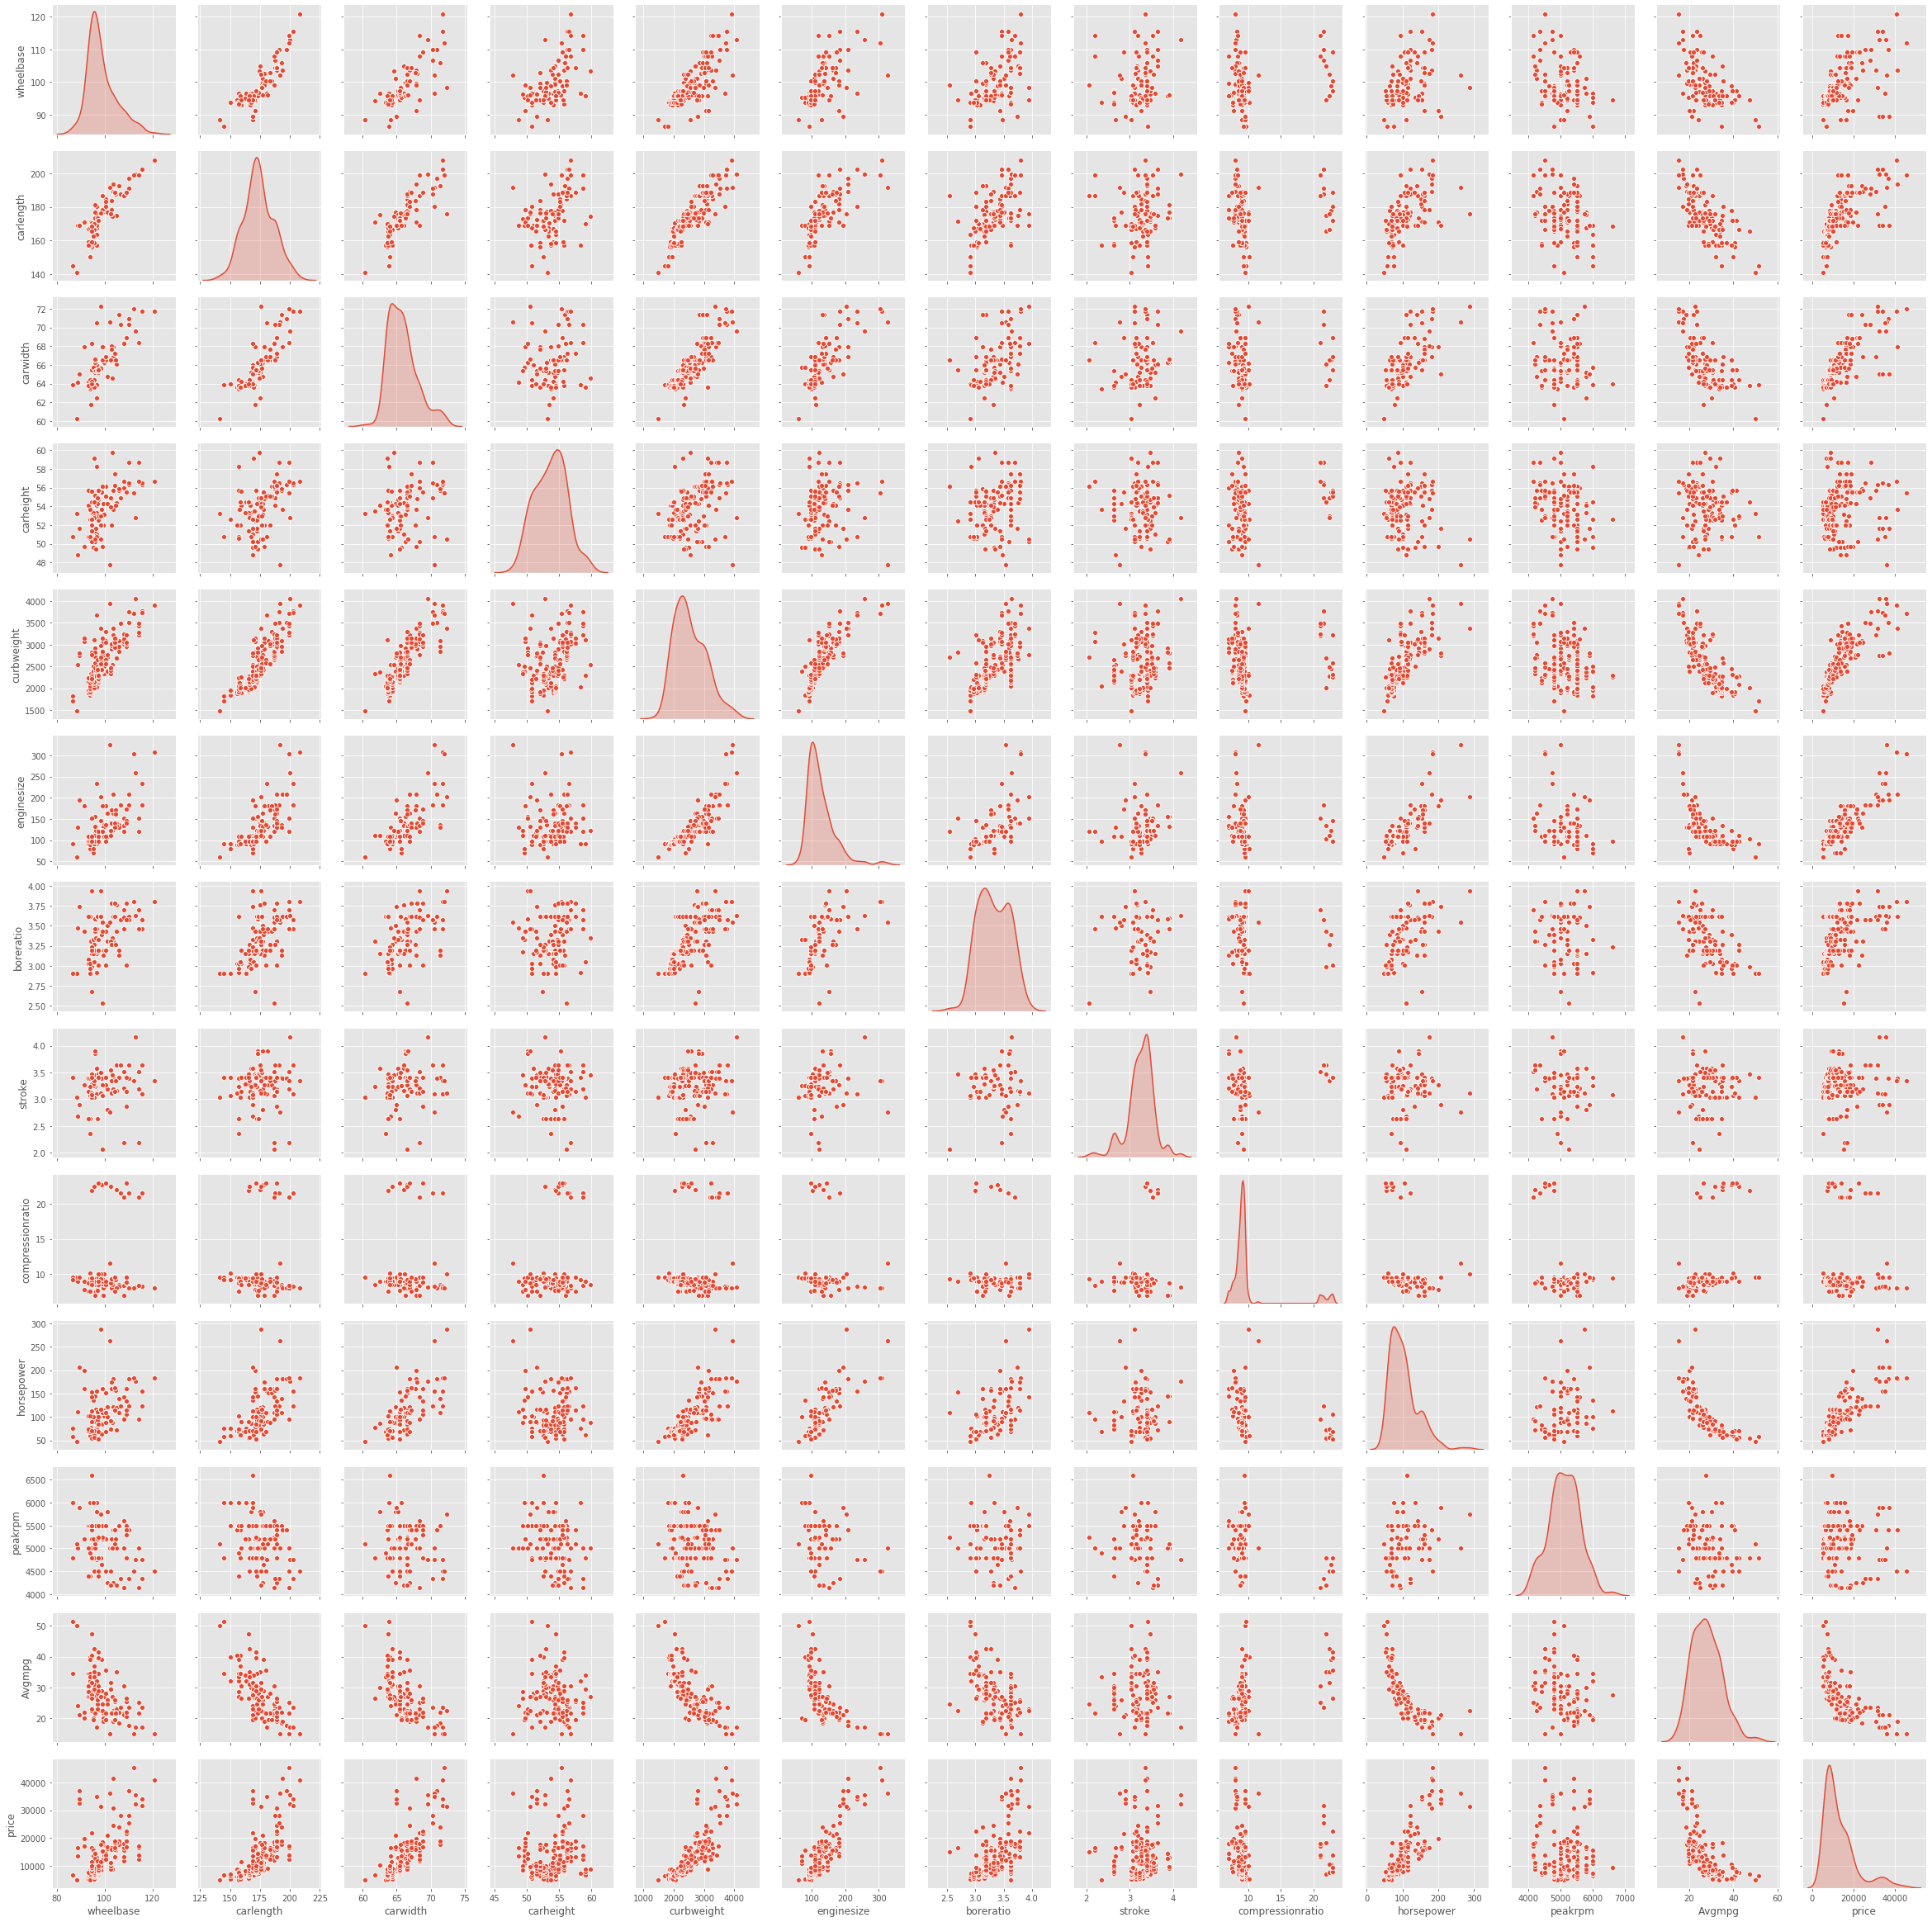

In [12]:
#viewing the pair plot `
sns.pairplot(df_numeric,diag_kind='kde')
plt.show()

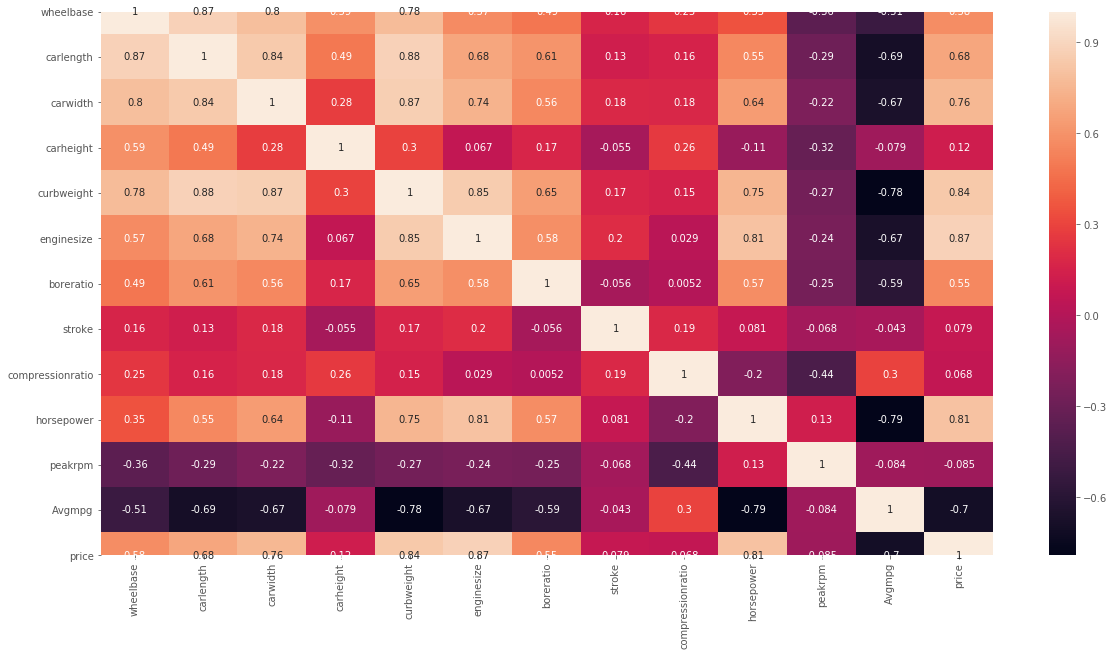

In [13]:
#heatmap
plt.figure(figsize=(20,10))
sns.heatmap(df_numeric.corr(),annot=True)
plt.show()

In [14]:
#removing the above said columns .
cols_to_remove=['wheelbase','carheight','stroke','compressionratio','peakrpm']
df_numeric.drop(cols_to_remove,1,inplace=True)

# Dealing with Categorical Features

In [15]:
df_catg=pd.concat((df_catg,df.iloc[:,-1]),1)
df_catg.head()

,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,enginetype,cylindernumber,fuelsystem,price
0,alfa-romero giulia,gas,std,two,convertible,rwd,front,dohc,four,mpfi,13495.0
1,alfa-romero stelvio,gas,std,two,convertible,rwd,front,dohc,four,mpfi,16500.0
2,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,ohcv,six,mpfi,16500.0
3,audi 100 ls,gas,std,four,sedan,fwd,front,ohc,four,mpfi,13950.0
4,audi 100ls,gas,std,four,sedan,4wd,front,ohc,five,mpfi,17450.0


In [16]:
#Extracting Car Maker
Car_Maker=df_catg['CarName'].apply(lambda x : x.split()[0])
df_catg.insert(1,'Car_Maker',Car_Maker)
df_catg.drop('CarName',1,inplace=True)

In [17]:
df_catg.Car_Maker.unique()

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'maxda', 'mazda', 'buick', 'mercury',
       'mitsubishi', 'Nissan', 'nissan', 'peugeot', 'plymouth', 'porsche',
       'porcshce', 'renault', 'saab', 'subaru', 'toyota', 'toyouta',
       'vokswagen', 'volkswagen', 'vw', 'volvo'], dtype=object)

In [18]:
#We have the same Makers names repeated, lets combine them

df_catg['Car_Maker']=df_catg['Car_Maker'].replace('maxda','mazda')
df_catg['Car_Maker']=df_catg['Car_Maker'].replace('Nissan','nissan')
df_catg['Car_Maker']=df_catg['Car_Maker'].replace('Nissan','nissan')
df_catg['Car_Maker']=df_catg['Car_Maker'].replace('porcshce','porsche')
df_catg['Car_Maker']=df_catg['Car_Maker'].replace('toyouta','toyota')
df_catg['Car_Maker']=df_catg['Car_Maker'].replace('vokswagen','volkswagen')
df_catg['Car_Maker']=df_catg['Car_Maker'].replace('vw','volkswagen')

df_catg['Car_Maker']=df_catg['Car_Maker'].apply(lambda x : x.capitalize())

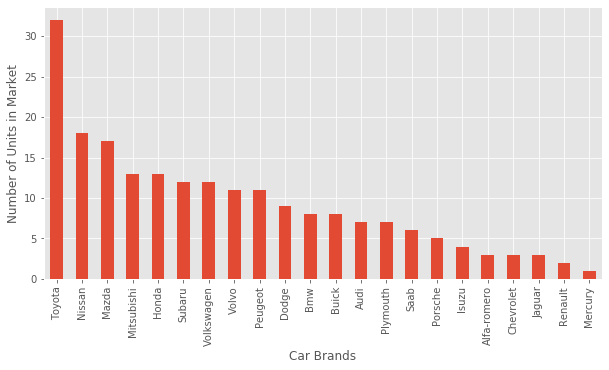

In [19]:
plt.figure(figsize=(10,5))
df_catg['Car_Maker'].value_counts().plot(kind='bar')
plt.xlabel('Car Brands')
plt.ylabel('Number of Units in Market')
plt.show()



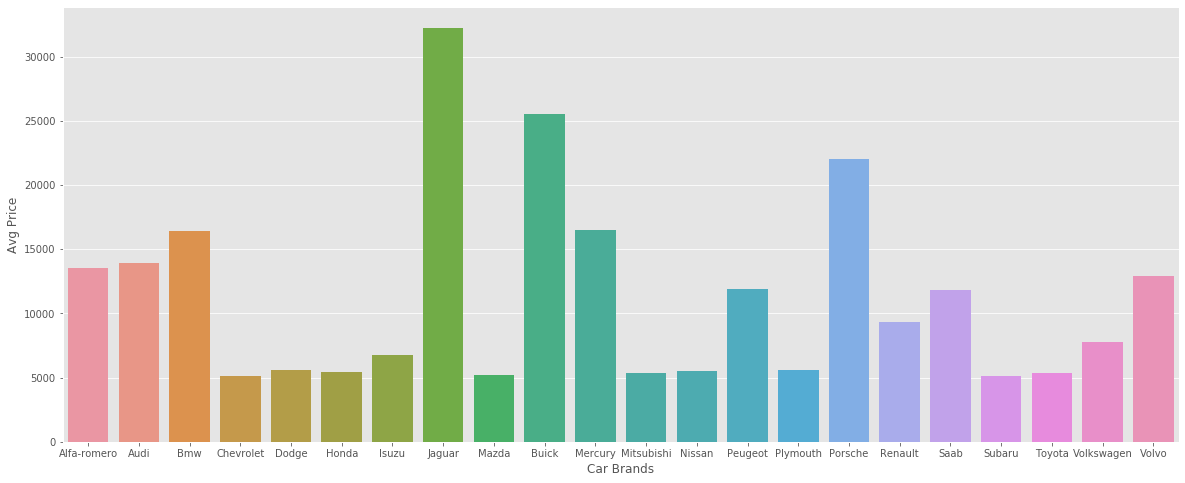

In [20]:
plt.figure(figsize=(20,8))
sns.barplot(df_catg['Car_Maker'],df_catg['price'],ci=None,estimator=np.min)
plt.xlabel('Car Brands')
plt.ylabel('Avg Price')
plt.show()


In [21]:
def Car_Class(x):
    price=x
    if price>0 and price<10000:
        return 'Low Budget'
    elif price>=10000 and price<20000:
        return 'Medium Budget'
    else:
        return 'High Bidget'
    

In [22]:
Car_class=df_catg['price'].apply(Car_Class)
df_catg.insert(len(df_catg.columns)-1,'Car_Class',Car_class)

In [23]:
df_catg.drop('Car_Maker',1,inplace=True)

In [24]:
d={'Low Budget':0,'Medium Budget':1,'High Bidget':2}

df_catg['Car_Class']=df_catg['Car_Class'].map(d)

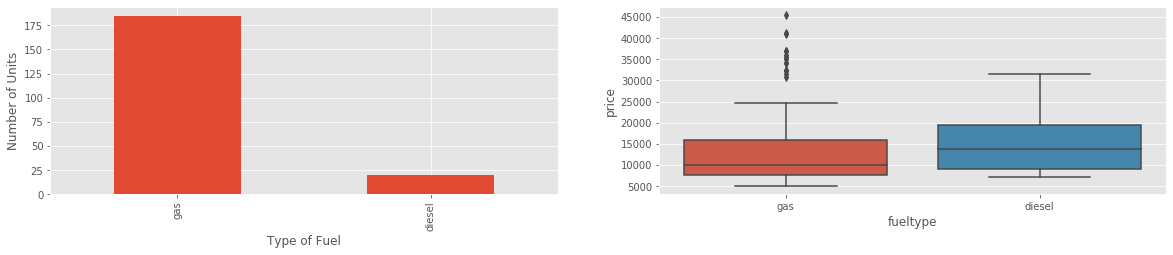

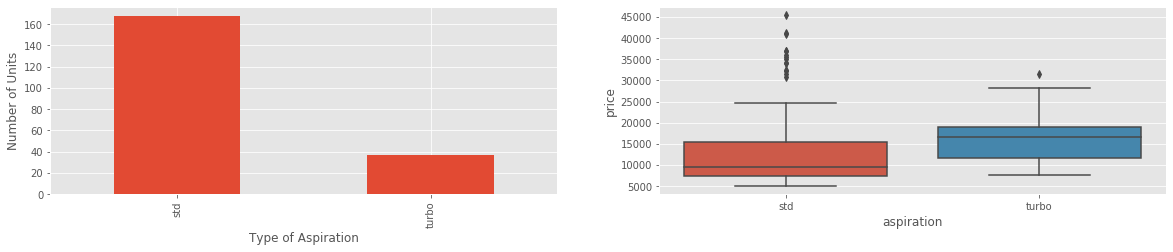

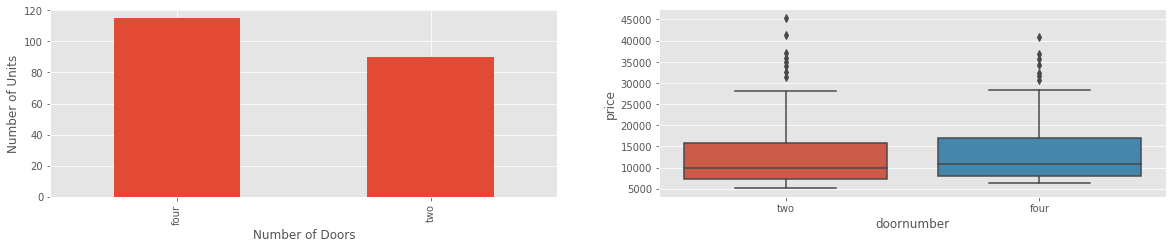

In [25]:

plt.figure(figsize=(20,20))
plt.subplot(521)
df_catg['fueltype'].value_counts().plot('bar')
plt.xlabel('Type of Fuel')
plt.ylabel('Number of Units')

plt.subplot(522)
sns.boxplot(df_catg['fueltype'],df_catg['price'])

#####################################################

plt.figure(figsize=(20,20))
plt.subplot(525)
df_catg['aspiration'].value_counts().plot('bar')
plt.xlabel('Type of Aspiration')
plt.ylabel('Number of Units')

plt.subplot(526)
sns.boxplot(df_catg['aspiration'],df_catg['price'])

######################################################

plt.figure(figsize=(20,20))
plt.subplot(529)
df_catg['doornumber'].value_counts().plot('bar')
plt.xlabel('Number of Doors')
plt.ylabel('Number of Units')

plt.subplot(5,2,10)
sns.boxplot(df_catg['doornumber'],df_catg['price'])
plt.show()


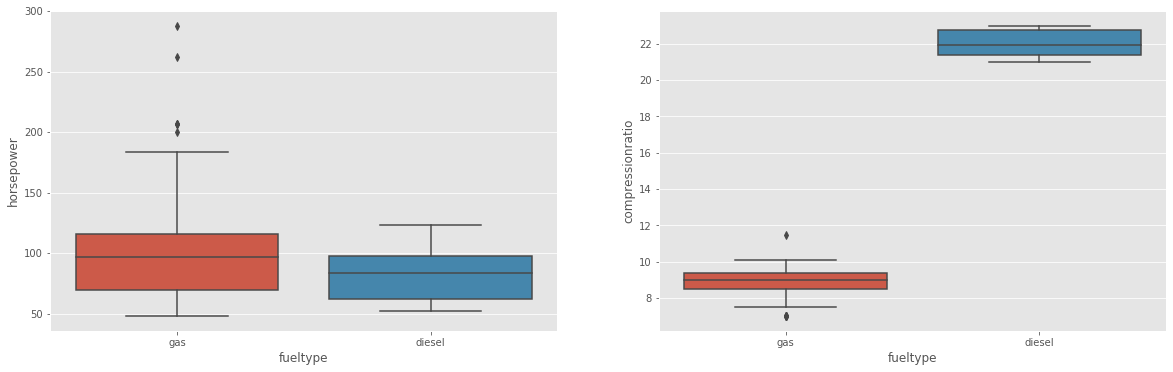

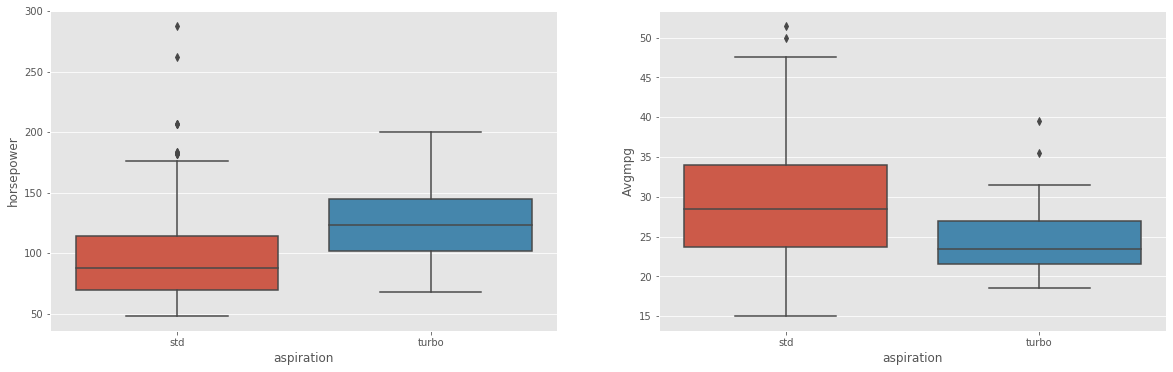

In [26]:
plt.figure(figsize=(20,20))
plt.subplot(321)
sns.boxplot(df_catg['fueltype'],df_numeric['horsepower'])

plt.subplot(322)
sns.boxplot(df_catg['fueltype'],df['compressionratio'])

##########################################################

plt.figure(figsize=(20,20))
plt.subplot(325)
sns.boxplot(x=df_catg['aspiration'],y=df_numeric['horsepower'])

plt.subplot(326)
sns.boxplot(df_catg['aspiration'],df_numeric['Avgmpg'])
plt.show()

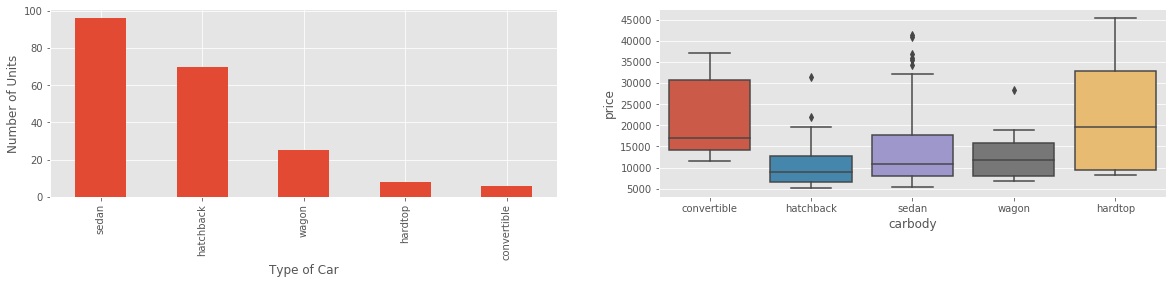

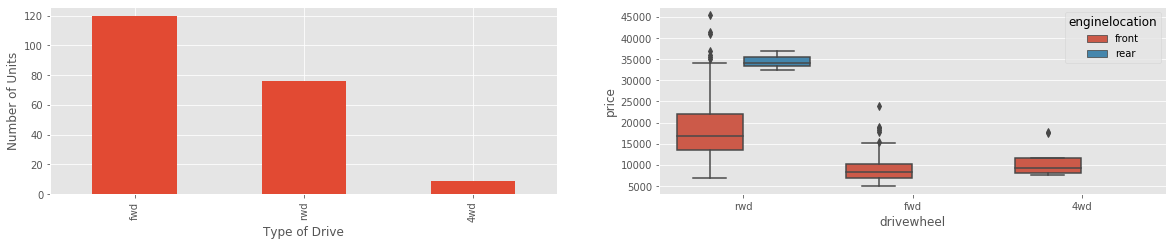

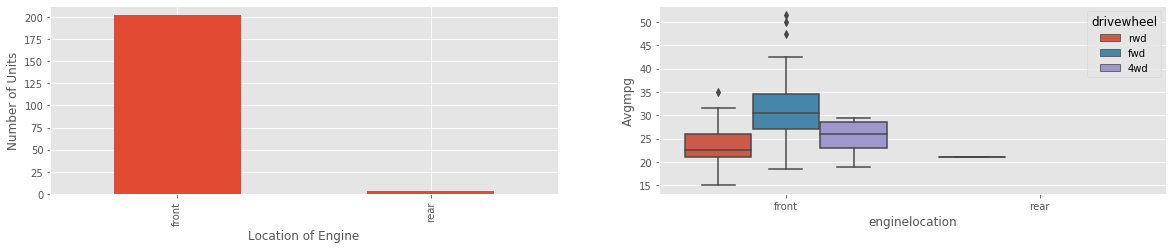

In [27]:
plt.figure(figsize=(20,20))
plt.subplot(521)
df_catg['carbody'].value_counts().plot('bar')
plt.xlabel('Type of Car')
plt.ylabel('Number of Units')

plt.subplot(522)
sns.boxplot(df_catg['carbody'],df_catg['price'])
##################################################

plt.figure(figsize=(20,20))
plt.subplot(525)
df_catg['drivewheel'].value_counts().plot('bar')
plt.xlabel('Type of Drive')
plt.ylabel('Number of Units')

plt.subplot(526)
sns.boxplot(df_catg['drivewheel'],df_catg['price'],hue=df_catg['enginelocation'])
###################################################

plt.figure(figsize=(20,20))
plt.subplot(529)
df_catg['enginelocation'].value_counts().plot('bar')
plt.xlabel('Location of Engine')
plt.ylabel('Number of Units')

plt.subplot(5,2,10)
sns.boxplot(hue=df_catg['drivewheel'],y=df_numeric['Avgmpg'],x=df_catg['enginelocation'])
plt.show()

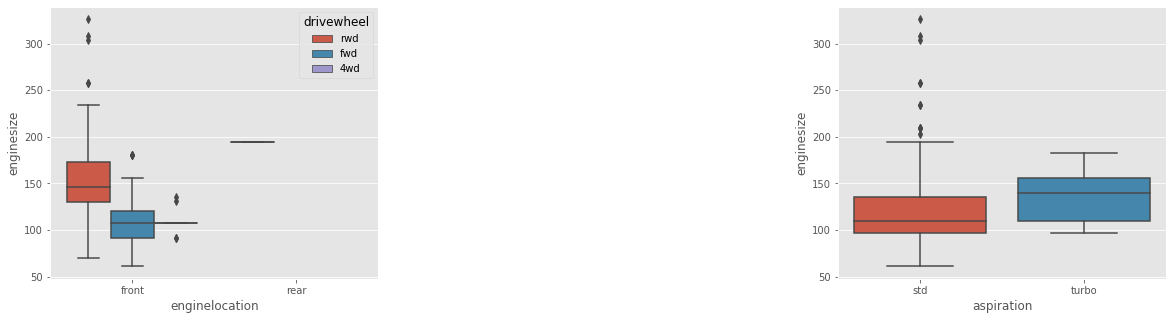

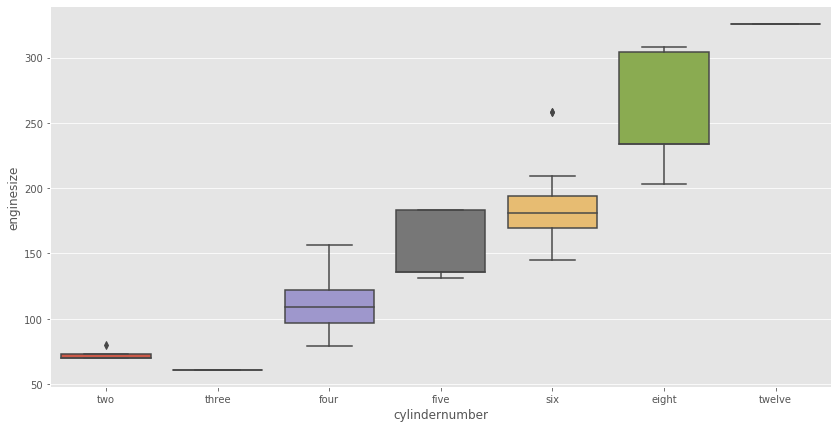

In [28]:
plt.figure(figsize=(20,5))
plt.subplot(131)
sns.boxplot(hue=df_catg['drivewheel'],y=df_numeric['enginesize'],x=df_catg['enginelocation'])

plt.subplot(133)
sns.boxplot(df_catg['aspiration'],df_numeric['enginesize'])
plt.show()
##################################################################

plt.figure(figsize=(14,7))
sns.boxplot(df_catg['cylindernumber'],df_numeric['enginesize'],order=['two','three','four','five','six','eight','twelve'])
plt.show()


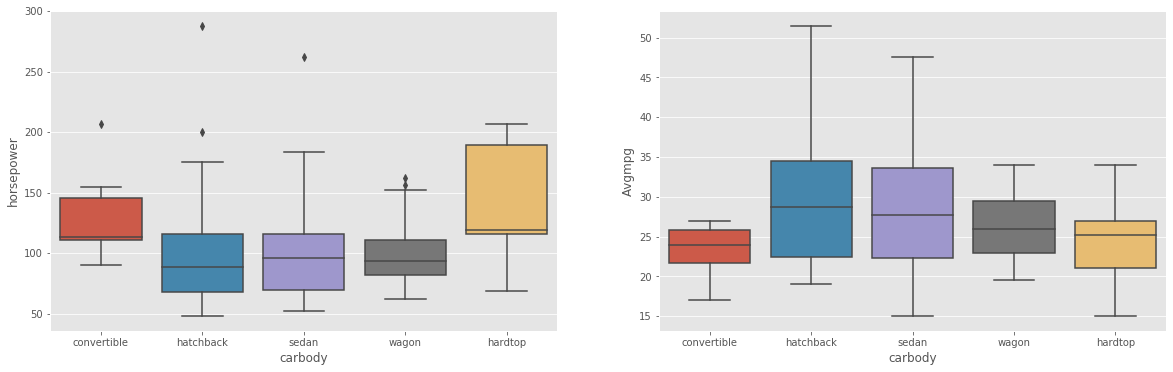

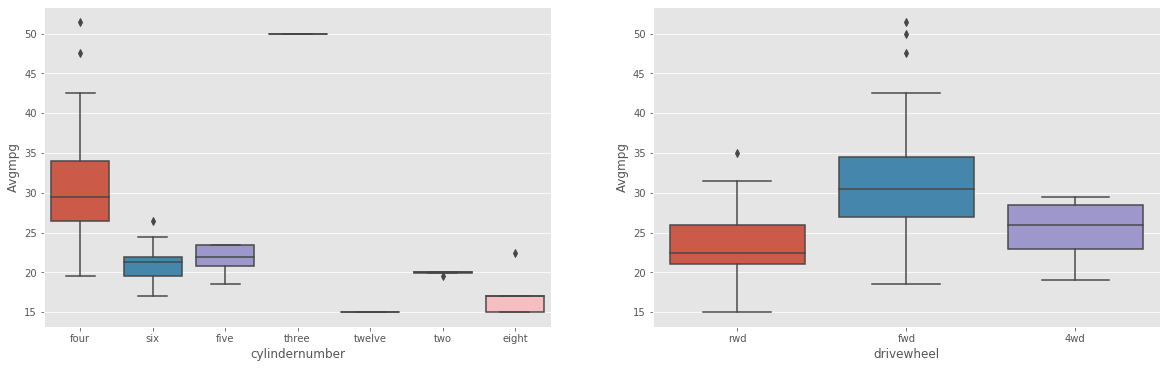

In [29]:
plt.figure(figsize=(20,20))
plt.subplot(321)
sns.boxplot(df_catg['carbody'],df['horsepower'])

plt.subplot(322)
sns.boxplot(df_catg['carbody'],df_numeric['Avgmpg'])
#########################################################

plt.figure(figsize=(20,20))
plt.subplot(325)
sns.boxplot(df_catg['cylindernumber'],df_numeric['Avgmpg'])

plt.subplot(326)
sns.boxplot(df_catg['drivewheel'],df_numeric['Avgmpg'])

plt.show()

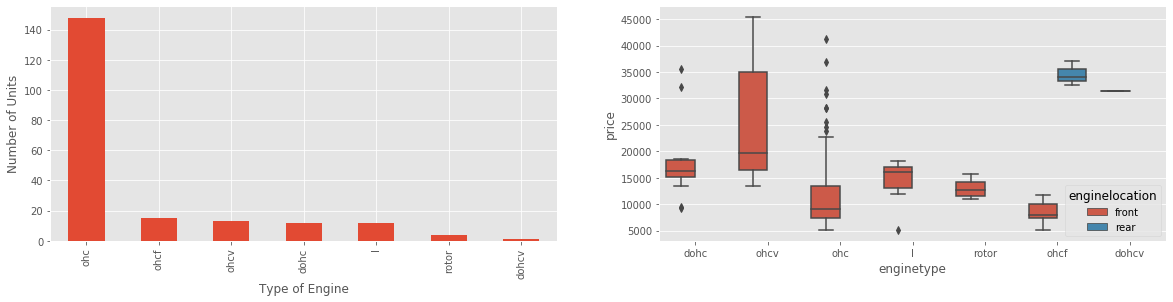

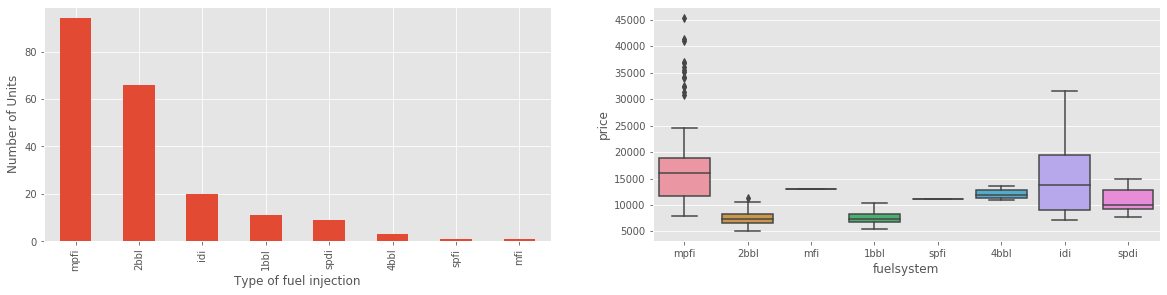

In [30]:
plt.figure(figsize=(20,25))
plt.subplot(521)
df_catg['enginetype'].value_counts().plot('bar')
plt.xlabel('Type of Engine')
plt.ylabel('Number of Units')

plt.subplot(522)
sns.boxplot(df_catg['enginetype'],df_catg['price'],hue=df_catg['enginelocation'])
##################################################################################

plt.figure(figsize=(20,25))
plt.subplot(525)
df_catg['fuelsystem'].value_counts().plot('bar')
plt.xlabel('Type of fuel injection')
plt.ylabel('Number of Units')

plt.subplot(526)
sns.boxplot(df_catg['fuelsystem'],df_numeric['price'])
plt.show()


# Model Building : Lineear Regression 


In [31]:
df_numeric.head()

,carlength,carwidth,curbweight,enginesize,boreratio,horsepower,Avgmpg,price
0,168.8,64.1,2548,130,3.47,111,24.0,13495.0
1,168.8,64.1,2548,130,3.47,111,24.0,16500.0
2,171.2,65.5,2823,152,2.68,154,22.5,16500.0
3,176.6,66.2,2337,109,3.19,102,27.0,13950.0
4,176.6,66.4,2824,136,3.19,115,20.0,17450.0


In [32]:
#removig as already said above
df_numeric.drop('boreratio',1,inplace=True)
df_numeric.head()

,carlength,carwidth,curbweight,enginesize,horsepower,Avgmpg,price
0,168.8,64.1,2548,130,111,24.0,13495.0
1,168.8,64.1,2548,130,111,24.0,16500.0
2,171.2,65.5,2823,152,154,22.5,16500.0
3,176.6,66.2,2337,109,102,27.0,13950.0
4,176.6,66.4,2824,136,115,20.0,17450.0


In [33]:
#removing price column from catg data frame as already present in numeric one
df_catg=df_catg[df_catg.columns[:-1]]

In [34]:
#removig as already said above
df_catg=df_catg.drop(['cylindernumber','doornumber'],1)

In [35]:
cat_cols=df_catg.columns[:-1]

In [36]:
#renaming the data points in categorical feature with count <20 to other 
for col in cat_cols:
    a=df_catg[col].value_counts()
    for  j,i in enumerate(a):
        if i<20:
            name=a.index[j]
            df_catg=df_catg.replace(name,'other')

In [37]:
for i in df_catg.columns:
    print(df_catg[i].value_counts())

gas       185
diesel     20
Name: fueltype, dtype: int64
std      168
turbo     37
Name: aspiration, dtype: int64
sedan        96
hatchback    70
wagon        25
other        14
Name: carbody, dtype: int64
fwd      120
rwd       76
other      9
Name: drivewheel, dtype: int64
front    202
other      3
Name: enginelocation, dtype: int64
ohc      148
other     57
Name: enginetype, dtype: int64
mpfi     94
2bbl     66
other    25
idi      20
Name: fuelsystem, dtype: int64
0    100
1     79
2     26
Name: Car_Class, dtype: int64


In [38]:
#removing the other data points whose counts is <20

for col in cat_cols:
    count = df_catg[col].value_counts()
    k = count.index[count>20][:-1]
    
    for cat in k:
        name = col + ' ' + cat
        df_catg[name] = (df_catg[col] == cat).astype(int)
    del df_catg[col]

In [39]:
df=pd.concat((df_numeric,df_catg),1)
df.head()

,carlength,carwidth,curbweight,enginesize,horsepower,Avgmpg,price,Car_Class,aspiration std,carbody sedan,carbody hatchback,drivewheel fwd,enginetype ohc,fuelsystem mpfi,fuelsystem 2bbl
0,168.8,64.1,2548,130,111,24.0,13495.0,1,1,0,0,0,0,1,0
1,168.8,64.1,2548,130,111,24.0,16500.0,1,1,0,0,0,0,1,0
2,171.2,65.5,2823,152,154,22.5,16500.0,1,1,0,1,0,0,1,0
3,176.6,66.2,2337,109,102,27.0,13950.0,1,1,1,0,1,1,1,0
4,176.6,66.4,2824,136,115,20.0,17450.0,1,1,1,0,0,1,1,0


In [40]:
df=df.transform(lambda x : np.log1p(x))

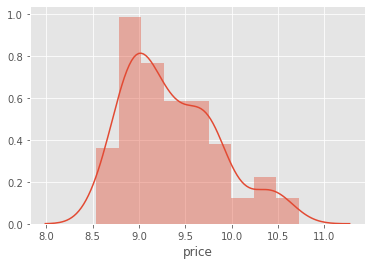

In [41]:
#target feature is approx normal 
sns.distplot(df['price'])

In [42]:
X=df.drop('price',1)
y=df['price']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=45)

In [43]:
print(X.shape)

(205, 14)


In [44]:
#as there are 14 columns , lets select around 5 featres 

lr=LinearRegression()
rfe=RFE(lr,5)
rfe=rfe.fit(X_train,y_train)


In [45]:
X_train_new=X_train[X_train.columns[rfe.support_]]
X_test_new=X_test[X_train_new.columns]
X_train_new.head()

,carwidth,enginesize,horsepower,Car_Class,drivewheel fwd
104,4.232656,5.204007,5.081404,0.693147,0.000000
171,4.198705,4.990433,4.762174,0.693147,0.000000
187,4.197202,4.584967,4.234107,0.000000,0.693147
143,4.195697,4.691348,4.553877,0.000000,0.693147
180,4.212128,5.147494,5.056246,0.693147,0.000000


In [46]:
model_lr=lr.fit(X_train_new,y_train)

print(f'The R square value for the training data is {round(model_lr.score(X_train_new,y_train)*100,2)}')
print(f'The R square value for the testing data is {round(model_lr.score(X_test_new,y_test)*100,2)}')


The R square value for the training data is 92.7
The R square value for the testing data is 88.08


In [47]:
#as the data points are only 200, lets perforn 3 fold CV
X1=X[X_train_new.columns]

print(f'The mean R square value we get by this model is {round(cross_val_score(lr,X1,y,cv=3).mean()*100,2)}')

The mean R square value we get by this model is 88.16


In [48]:
pd.DataFrame(zip(X_train_new.columns,model_lr.coef_),columns=['Col_name','Coeff_value'])

,Col_name,Coeff_value
0,carwidth,1.968827
1,enginesize,0.379204
2,horsepower,0.266391
3,Car_Class,0.590553
4,drivewheel fwd,-0.128597


In [49]:
X_const=sm.add_constant(X_train_new)
model_ols=sm.OLS(y_train,X_const).fit()
model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     373.5
Date:                Tue, 14 Apr 2020   Prob (F-statistic):           1.20e-81
Time:                        12:39:45   Log-Likelihood:                 82.821
No. Observations:                 153   AIC:                            -153.6
Df Residuals:                     147   BIC:                            -135.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.1596      2.444     -0.884      0.378      -6.990       2.671
carwidth           1.9688      0.614      3.208      0.002       0.756       3.182
enginesize         0.3792      0.080      4.715      0.000       0.220       0.538
horsepower         0.2664      0.065      4.085      0.000       0.138       0.395
Car_Class          0.5906      0.052     11.321      0.000       0.487       0.694
drivewheel fwd    -0.1286      0.046     -2.824      0.005      -0.219      -0.039
==============================================================================
Omnibus:                        0.237   Durbin-Watson:                   2.275
Prob(Omnibus):                  0.888   Jarque-Bera (JB):                0.403
Skew:                          -0.027   Prob(JB):                        0.818
Kurtosis:                       2.755   Cond. No.                     1.73e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.73e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [50]:
#cheking for multicollinearity

v=[VIF(X_const.values,i) for i in range(X_const.shape[1])]

pd.DataFrame(zip(X_const,v),columns=['col_name','vif_value'])

,col_name,vif_value
0,const,44286.011765
1,carwidth,2.845092
2,enginesize,3.954764
3,horsepower,4.009040
4,Car_Class,3.588051
5,drivewheel fwd,1.811901


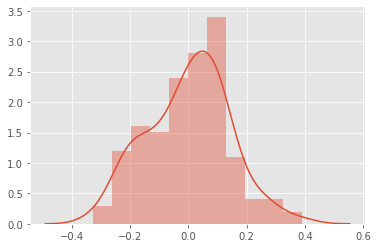

In [51]:
sns.distplot(model_ols.resid)
plt.show()

# Random Forest Regression

In [52]:
rf=RandomForestRegressor()
params={'max_depth':r(1,25), 'min_samples_split':r(2,20),
       'min_samples_leaf':r(2,15),'max_samples':r(50,75),'max_features':r(5,7),'n_estimators':r(1,50)}

rsearch=RandomizedSearchCV(rf,param_distributions=params,n_jobs=-1,cv=3,return_train_score=True,random_state=45)

In [53]:
rsearch.fit(X_train_new,y_train)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [54]:
#the best estimator
print(rsearch.best_estimator_)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=16, max_features=5, max_leaf_nodes=None,
                      max_samples=59, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=9, min_weight_fraction_leaf=0.0,
                      n_estimators=28, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)


In [55]:
rsearch.best_params_

{'max_depth': 16,
 'max_features': 5,
 'max_samples': 59,
 'min_samples_leaf': 4,
 'min_samples_split': 9,
 'n_estimators': 28}

In [56]:
rfr=RandomForestRegressor(**rsearch.best_params_,random_state=45)

In [57]:
model_rfr=rfr.fit(X_train_new,y_train)

In [58]:
print(f'The R square value for the training data is {round(model_rfr.score(X_train_new,y_train)*100,2)}')
print(f'The R square value for the testing data is {round(model_rfr.score(X_test_new,y_test)*100,2)}')



The R square value for the training data is 94.89
The R square value for the testing data is 86.44


In [59]:
X2=X[X_train_new.columns]
print(f'The mean R square value we get by this model is {round(cross_val_score(rfr,X2,y,cv=3).mean()*100,2)}')

The mean R square value we get by this model is 88.94


In [60]:
#checking the normality of residuals
resid=y_train-model_rfr.predict(X_train_new)

print(f'P value for normality check is {stats.jarque_bera(resid)[1]}')
#Residuals are nomrmally disributed

P value for normality check is 0.5364551034250762


# Gradient Boost Regression 

In [61]:
gbr=GradientBoostingRegressor()

In [62]:
params_gb={'n_estimators':r(10,50),'min_samples_split':r(2,50),'min_samples_leaf':r(2,50),'max_depth':r(3,50)}

In [63]:
rsearch_gb=RandomizedSearchCV(gbr,param_distributions=params_gb,random_state=45,n_jobs=-1)

In [64]:
rsearch_gb.fit(X_train_new,y_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                          

In [65]:
rsearch_gb.best_params_

{'max_depth': 41,
 'min_samples_leaf': 6,
 'min_samples_split': 48,
 'n_estimators': 40}

In [66]:
g=GradientBoostingRegressor(**rsearch_gb.best_params_,random_state=45)

In [67]:
model_gb=g.fit(X_train_new,y_train)

In [68]:
print(f'The R square value for the training data is {round(model_gb.score(X_train_new,y_train)*100,2)}')
print(f'The R square value for the testing data is {round(model_gb.score(X_test_new,y_test)*100,2)}')
print(f'The mean R square value we get by this model is {round(cross_val_score(g,X2,y,cv=3).mean()*100,2)}')

The R square value for the training data is 96.86
The R square value for the testing data is 88.67
The mean R square value we get by this model is 89.51


In [69]:
resid=y_train-model_gb.predict(X_train_new)

print(f'P value for normality check is {stats.jarque_bera(resid)[1]}')
#Residuals are nomrmally disributed

P value for normality check is 0.7554989269222473


# Making Pipelines

In [70]:
from sklearn.pipeline import Pipeline

In [71]:
pipeline_lr=Pipeline([('lr_regression',LinearRegression())])
pipeline_rfr=Pipeline([('random_regression',RandomForestRegressor(**rsearch.best_params_,random_state=45))])
pipeline_gbr=Pipeline([('gradient_regression',GradientBoostingRegressor(**rsearch_gb.best_params_,random_state=45))])

In [72]:
pipelines = [pipeline_lr, pipeline_rfr, pipeline_gbr]
pipe_dict = {0: 'Linear Regression', 1: 'Random Forest Regression ', 2: 'Gradient Boost Regression'}

In [73]:
for model in pipelines:
    model.fit(X_train_new,y_train)

In [74]:
for i,model in enumerate(pipelines):
    print("{} Test Accuracy: {}".format(pipe_dict[i],round(model.score(X_train_new,y_train)*100,2)))

Linear Regression Test Accuracy: 92.7
Random Forest Regression  Test Accuracy: 94.89
Gradient Boost Regression Test Accuracy: 96.86


In [75]:
for i,model in enumerate(pipelines):
    print("{} Mean Accuracy: {}".format(pipe_dict[i],round((cross_val_score(model,X2,y,cv=5).mean()) *100),2))

Linear Regression Mean Accuracy: 87.0
Random Forest Regression  Mean Accuracy: 88.0
Gradient Boost Regression Mean Accuracy: 87.0


# Thus We can go with Random Forest Regression model 